In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
import torch

In [5]:
directory = 'datasets/cocoa_diseases'
class_mapping = {
    0: "phytophthora",
    1: "monilia",
    2: "healthy"
}

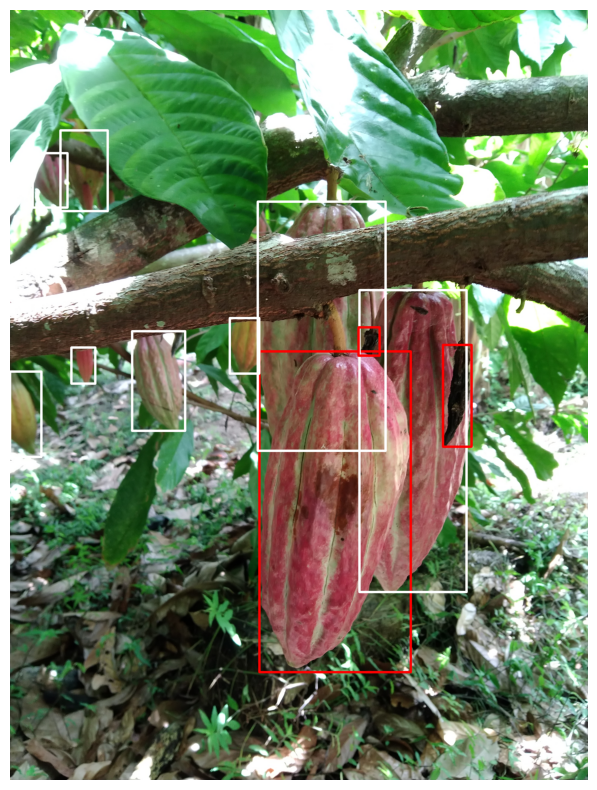

In [6]:
def visualize_image_with_bboxes(image_path, annotation_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(annotation_path, 'r') as file:
        annotations = file.readlines()

    height, width, _ = image.shape

    for annotation in annotations:
        values = annotation.strip().split()
        class_id = int(values[0])
        cx, cy, w, h = map(float, values[1:])

        x_min = int((cx - w / 2) * width)
        y_min = int((cy - h / 2) * height)
        x_max = int((cx + w / 2) * width)
        y_max = int((cy + h / 2) * height)

        color = (255, 255, 255)
        if class_id == 0:
            color = (255, 0, 0)
        elif class_id == 1:
            color = (255, 255, 0)

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 12)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


visualize_image_with_bboxes(directory+"/images/train/Fito1.jpg", directory+"/labels/train/Fito1.txt")

In [7]:
import torch

print("PyTorch CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("CUDA devices:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No device")


PyTorch CUDA version: 12.4
CUDA available: True
CUDA devices: 1
CUDA device name: NVIDIA GeForce GTX 1650


# Yolo setup

In [8]:
model = YOLO("yolo11n.pt")

train_results = model.train(
    data="datasets/cocoa_diseases/cocoa_dataset.yaml",
    epochs=2,
    project="yolo11_base",
    imgsz=640,
    batch=4,  
    device="cuda", 
    workers=1  
)

In [ ]:
model = YOLO("yolo11_base/train2/weights/best.pt")
result = model.predict("random.jpg")
result[0].show()